# Build the data set

Um unser Projektziel umzusetzen, stellen wir uns einen Datensatz zusammen, der folgende Daten enthält:

- tägliche Anzahl gemessener Fahrradfahrer von Zähler in Freiburg (channel name: 'FR1 Dreisam / Hindenburgstr.')
- mittlere tägliche Temperatur
- boolean, ob Tag Wochentag oder Werktag ist

Dazu importieren wir im Folgenden stündliche Zählerstände verschiedener Fahrradfahrerzählstationen aus dem Jahr 2021. Aus diesen Daten berechnen wir tägliche Zählersummen.

Wir extrahieren die Daten von genau einem Zähler (Freiburg, channel name: 'FR1 Dreisam / Hindenburgstr.') und betrachten in der Analyse nur die täglichen Zählersummen dieses Zählers.

Für den Standort dieses Zählers importieren wir Temperaturdaten.

Außerdem berechnen wir für jedes Datum vom 2021-01-01 bis 2021-12-31, ob es sich dabei um einen Werktag oder Wochenende handelt.

All diese Daten fügen wir dann in einem gemeinsamen Datensatz zusammen. Dieser ist weiter unten als 'combined_daily_dat' zu finden.

With hourly bike rider counts from https://www.mobidata-bw.de/dataset/eco-counter-fahrradzahler and temperature data from https://open-meteo.com/en/docs/historical-weather-api, we construct a dataset of the following form:

| daily mean temperature | is business day | daily bike rider count |
| --- | --- | --- |
|... | ... | ... |

_daily mean temperature_ is measured in °C.  
_is business day_ is either $0$ (Saturday or Sunday) or $1$ (Monday, Tuesday, Wednesday, Thursday or Friday)  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

## Import bike rider counts data

In [2]:
# paths to data (one file per month)
dat_paths = ['./../data/raw/bike_rider_counts/eco_counter_fahrradzaehler_20210' + str(i) + '.csv' for i in range(1,10)]
dat_paths = dat_paths + ['./../data/raw/bike_rider_counts/eco_counter_fahrradzaehler_2021' + str(i) + '.csv' for i in range(10,13)]

# read in the data
dats = [pd.read_csv(path) for path in dat_paths]

# concatenate monthly data to get data of whole year in one dataframe
dat = pd.concat(dats)

In [3]:
# check whether import of data worked
dat.head()

,timestamp,iso_timestamp,zählstand,stand,standort,channel_name,channel_id,counter_site,counter_site_id,domain_name,domain_id,longitude,latitude,timezone,interval,counter_serial
0,2021-01-01T01:00:00+0000,2021-01-01T01:00:00+0100,2,0,Stadt Heidelberg,Channel 1 Richtung West,101012161,Plöck,100012161,NVBW - Nahverkehrsgesellschaft Baden- Württemberg,6598,8.698543,49.40913,(UTC+01:00) Europe/Berlin;DST,15,Y2H22032496
1,2021-01-01T02:00:00+0000,2021-01-01T02:00:00+0100,0,0,Stadt Heidelberg,Channel 1 Richtung West,101012161,Plöck,100012161,NVBW - Nahverkehrsgesellschaft Baden- Württemberg,6598,8.698543,49.40913,(UTC+01:00) Europe/Berlin;DST,15,Y2H22032496
2,2021-01-01T03:00:00+0000,2021-01-01T03:00:00+0100,1,0,Stadt Heidelberg,Channel 1 Richtung West,101012161,Plöck,100012161,NVBW - Nahverkehrsgesellschaft Baden- Württemberg,6598,8.698543,49.40913,(UTC+01:00) Europe/Berlin;DST,15,Y2H22032496
3,2021-01-01T04:00:00+0000,2021-01-01T04:00:00+0100,1,0,Stadt Heidelberg,Channel 1 Richtung West,101012161,Plöck,100012161,NVBW - Nahverkehrsgesellschaft Baden- Württemberg,6598,8.698543,49.40913,(UTC+01:00) Europe/Berlin;DST,15,Y2H22032496
4,2021-01-01T05:00:00+0000,2021-01-01T05:00:00+0100,2,0,Stadt Heidelberg,Channel 1 Richtung West,101012161,Plöck,100012161,NVBW - Nahverkehrsgesellschaft Baden- Württemberg,6598,8.698543,49.40913,(UTC+01:00) Europe/Berlin;DST,15,Y2H22032496


Eine Zeile entspricht einer Messung. Gemessen wird stündlich. Nicht für jede Messstelle sind das ganze Jahr über Daten gelistet.

Bisher versteht ich den Datensatz folgendermaßen:  
Innerhalb eines 'standort' (siehe Spaltenname oben) gibt es verschiedene 'counter_site', an denen es wiederum verschiedene 'channel_name' geben kann.

Beispiel:  
Am Standort 'Stadt Freiburg' gibt es 3 'counter_sites' ('FR1 Dreisam / Otto-Wels-Str.', 'FR2 Güterbahn / Ferd.-Weiß-Str.', und 'FR3 Eschholzstr. / Egonstr.'), an denen es dann wiederum jeweils 'channel_name' gibt.

### Compute daily counts

Measurements (bike rider counts) above are given hourly. Now, we sum them to get daily counts.

We want to sum the counts of one day at one counter.  
Before we can simply compute daily sums, we have to adjust the dates to "correct" for counts collected at midnight:  
Counts collected at midnight reflect bikers that passed the counting station in the hour before midnight. Therefore, they have to be taken into account in the sum for the "day before".

In [4]:
# add date information to dataframe

# make 'timestamp' date
dat['timestamp'] = pd.to_datetime(dat['timestamp'])

# add simpler date format to each measurement to make grouping by day easier
# For each measurement (row), we want to know on which day the data was 
# collected. In order to adjust for counts collected at midnight, we shift the 
# daytime by 1 hour before converting it to date.
# (Thereby, we can simply compute daily sums in the cell below;
#  adding "midnight counts" to the day before by shifting the daytime by 1 hour.)
dat['date'] = (dat['timestamp'] - pd.Timedelta(1, 'h')).dt.date

# determine for each date whether it is a business day
dat['is_busday'] = (dat['timestamp'] - pd.Timedelta(1, 'h')).dt.dayofweek < 5 # for Monday-Friday: dayofweek < 5

In [5]:
# sum counts of one day at one counting station
counters_by_daytype_daily = dat.groupby(by=['standort', 'counter_site', 'channel_name', 'date', 'is_busday'], as_index=False)['zählstand'].sum()

In [6]:
counters_by_daytype_daily

,standort,counter_site,channel_name,date,is_busday,zählstand
0,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-01,True,521
1,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-02,False,1131
2,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-03,False,764
3,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-04,True,1607
4,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-05,True,1668
...,...,...,...,...,...,...
27596,Stadt Ulm,Blautal Lupferbrücke,Blautal Lupferbrücke Ri. Süden,2021-04-26,True,653
27597,Stadt Ulm,Blautal Lupferbrücke,Blautal Lupferbrücke Ri. Süden,2021-04-27,True,708
27598,Stadt Ulm,Blautal Lupferbrücke,Blautal Lupferbrücke Ri. Süden,2021-04-28,True,630
27599,Stadt Ulm,Blautal Lupferbrücke,Blautal Lupferbrücke Ri. Süden,2021-04-29,True,382


In [7]:
# TODO get overview over data
cities = list(set(dat['standort']))
print('The dataset contains bike rider counts for the following cities:', cities)

The dataset contains bike rider counts for the following cities: ['Stadt Ludwisburg', 'Stadt Konstanz', 'Stadt Heidelberg', 'Stadt Freiburg', 'Stadt Offenburg', 'Stadt Ulm']




city:  Stadt Ludwisburg
citydat.shape:  (10710, 6)
	 countersite:  Friedrich-Ebert-Straße
	 countersitedat.shape:  (1336, 6)
	 	 channel name:  Radweg C & D IN
	 	 channeldat.shape:  (334, 6)
	 	 channel name:  Straße A & B OUT
	 	 channeldat.shape:  (334, 6)
	 	 channel name:  Straße A & B IN
	 	 channeldat.shape:  (334, 6)
	 	 channel name:  Radweg C & D OUT
	 	 channeldat.shape:  (334, 6)
	 countersite:  Bismarckstraße
	 countersitedat.shape:  (652, 6)
	 	 channel name:  Bismarckstraße Stadtauswärts
	 	 channeldat.shape:  (326, 6)
	 	 channel name:  Bismarckstraße Stadteinwärts
	 	 channeldat.shape:  (326, 6)
	 countersite:  Kesseläcker (Verl. Nussackerweg)
	 countersitedat.shape:  (702, 6)
	 	 channel name:  Kesseläcker (Verl. Nussackerweg) Stadteinwärts
	 	 channeldat.shape:  (351, 6)
	 	 channel name:  Kesseläcker (Verl. Nussackerweg) Stadtauswärts
	 	 channeldat.shape:  (351, 6)
	 countersite:  Zugwiesen
	 countersitedat.shape:  (674, 6)
	 	 channel name:  Zugwiesen Stadteinwä

/tmp/ipykernel_9909/3409266784.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(nrows=1, ncols=len(channels), figsize=(15,4))


	 	 channel name:  Channel 4 OUT
	 	 channeldat.shape:  (365, 6)
	 	 channel name:  Channel 3 IN
	 	 channeldat.shape:  (365, 6)


city:  Stadt Freiburg
citydat.shape:  (1825, 6)
	 countersite:  FR1 Dreisam / Otto-Wels-Str.
	 countersitedat.shape:  (730, 6)
	 	 channel name:  FR1 Dreisam / Hindenburgstr. [Bike]
	 	 channeldat.shape:  (365, 6)
	 	 channel name:  FR1 Dreisam / Hindenburgstr.
	 	 channeldat.shape:  (365, 6)
	 countersite:  FR2 Güterbahn / Ferd.-Weiß-Str.
	 countersitedat.shape:  (365, 6)
	 	 channel name:  FR2 Güterbahn / Ferd.-Weiß-Str.
	 	 channeldat.shape:  (365, 6)
	 countersite:  FR3 Eschholzstr. / Egonstr.
	 countersitedat.shape:  (730, 6)
	 	 channel name:  Richtung Norden (Zelt 01_OUT)
	 	 channeldat.shape:  (365, 6)
	 	 channel name:  Richtung Süden (Zelt 01_IN)
	 	 channeldat.shape:  (365, 6)


city:  Stadt Offenburg
citydat.shape:  (365, 6)
	 countersite:  Hauptstraße neu
	 countersitedat.shape:  (365, 6)
	 	 channel name:  Hauptstraße neu
	 	 channeldat.shape:

<Figure size 640x480 with 0 Axes>

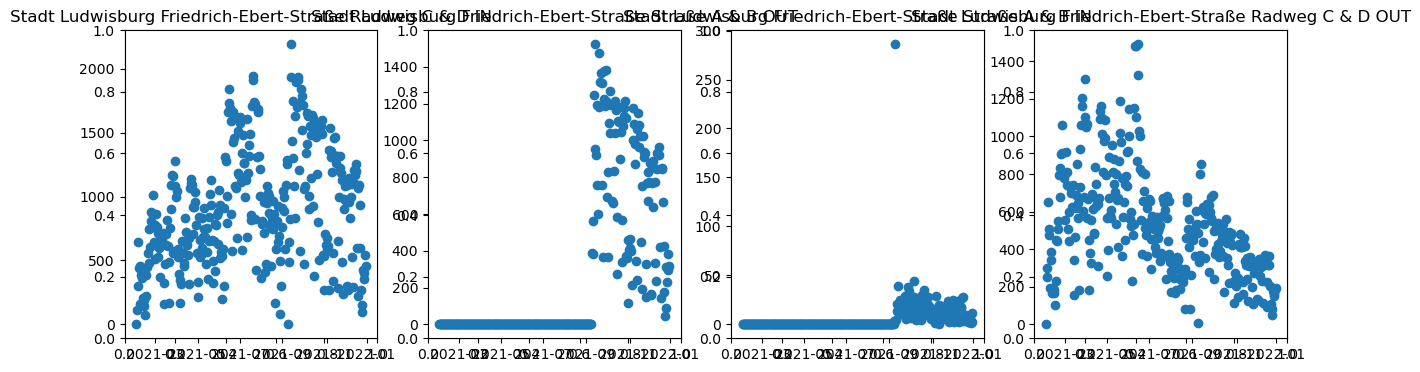

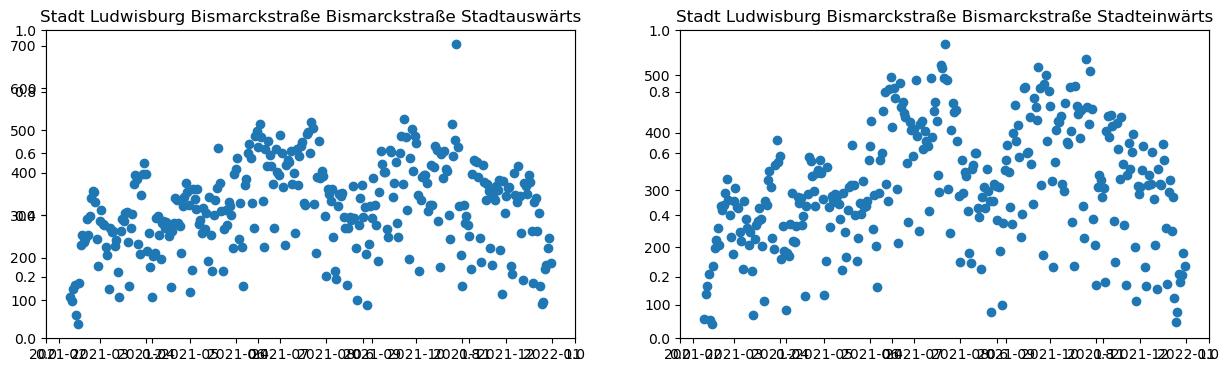

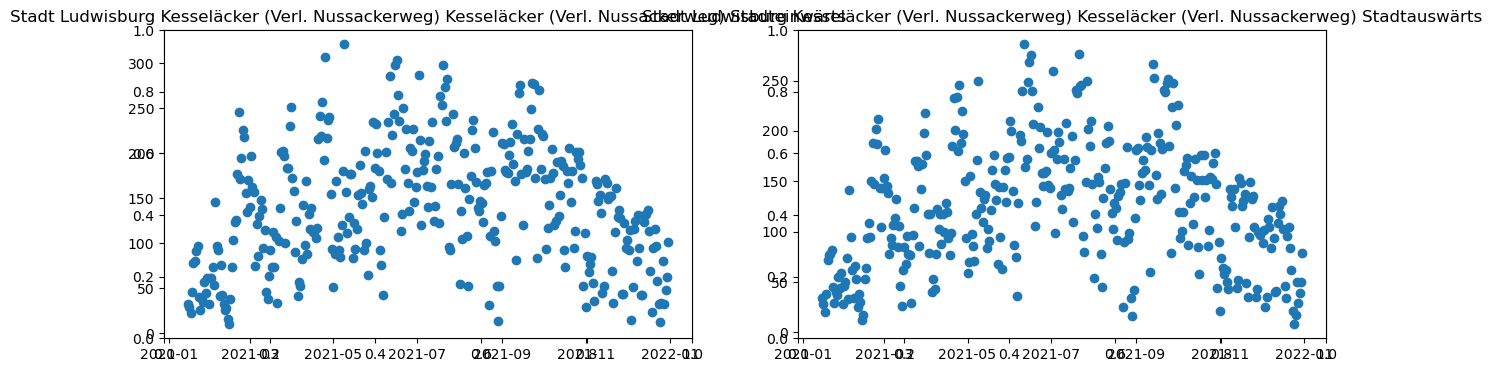

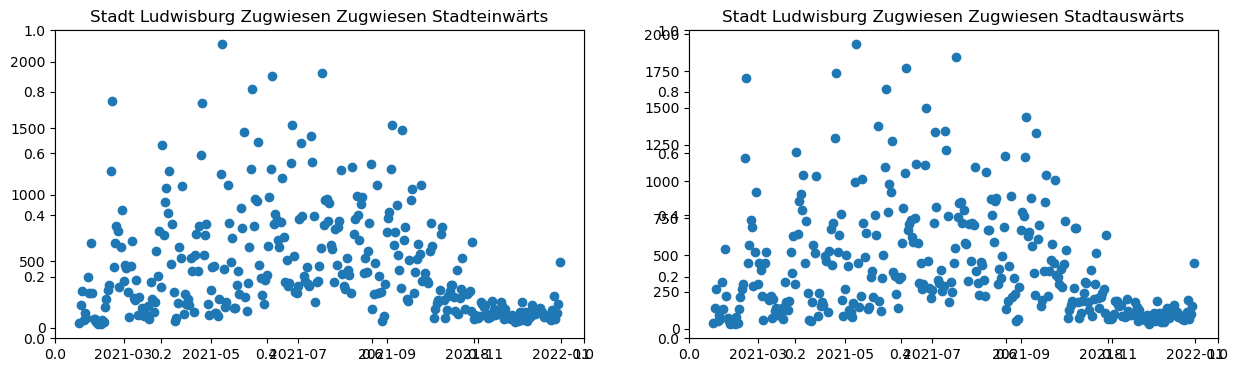

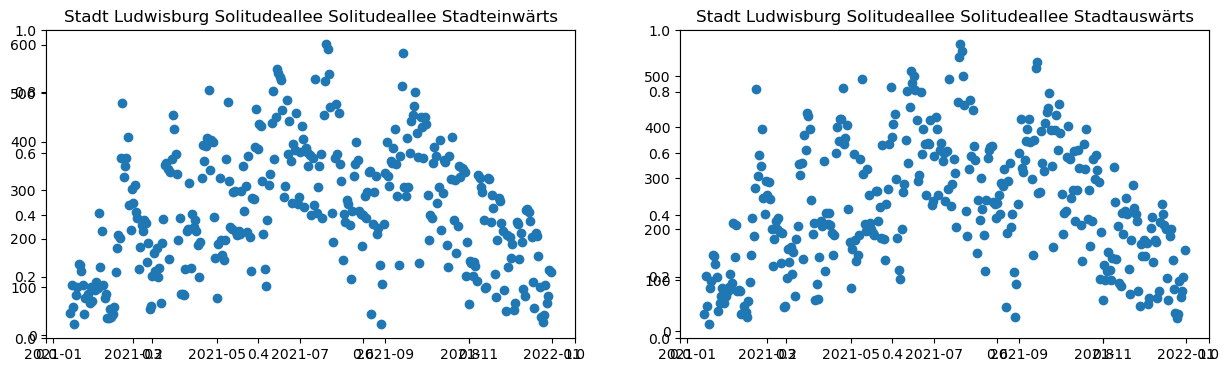

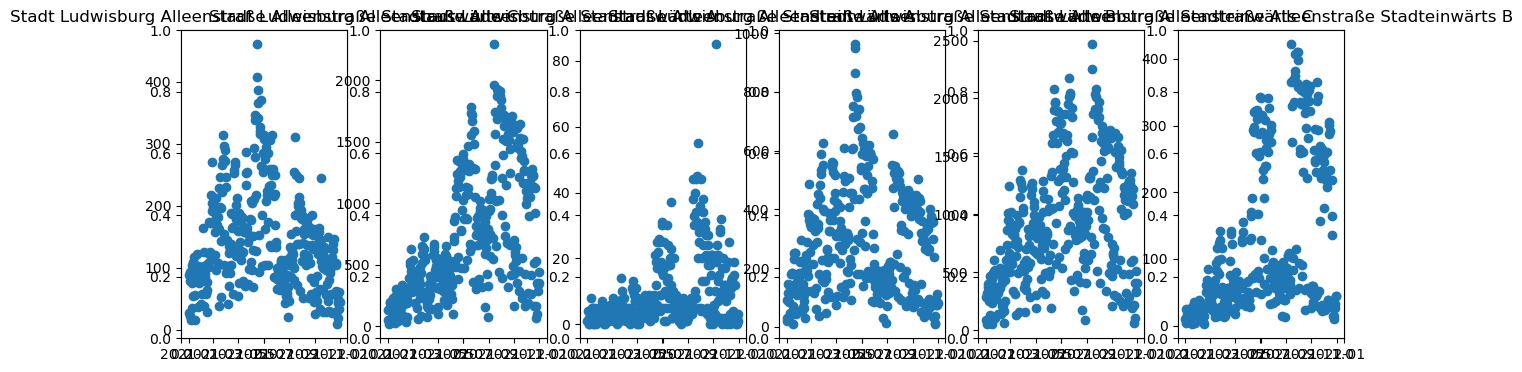

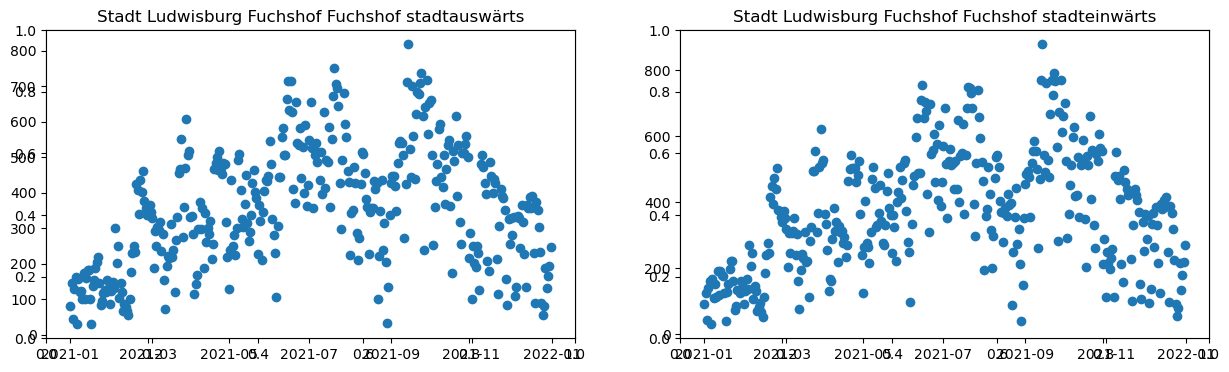

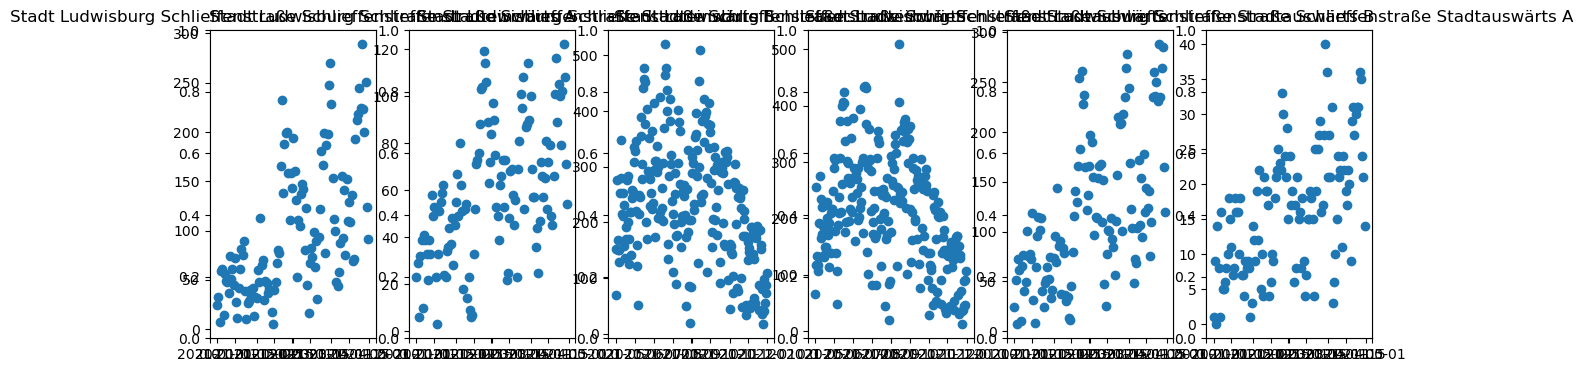

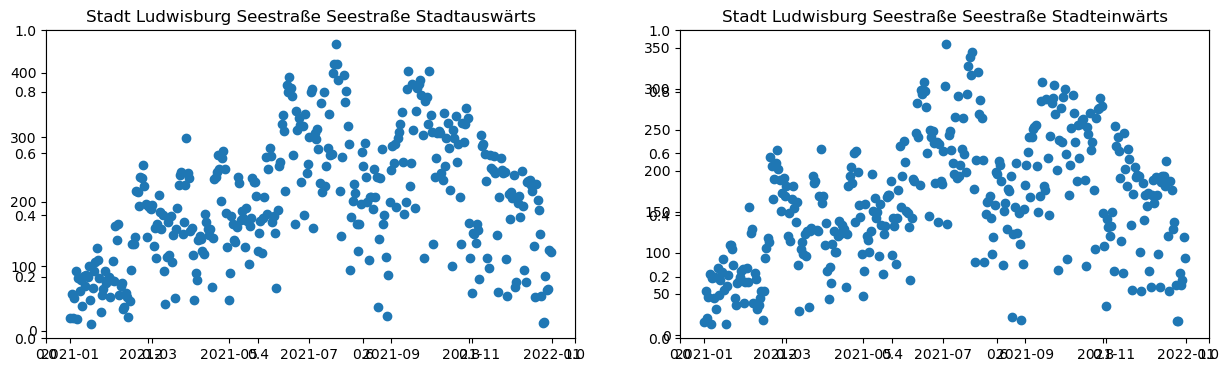

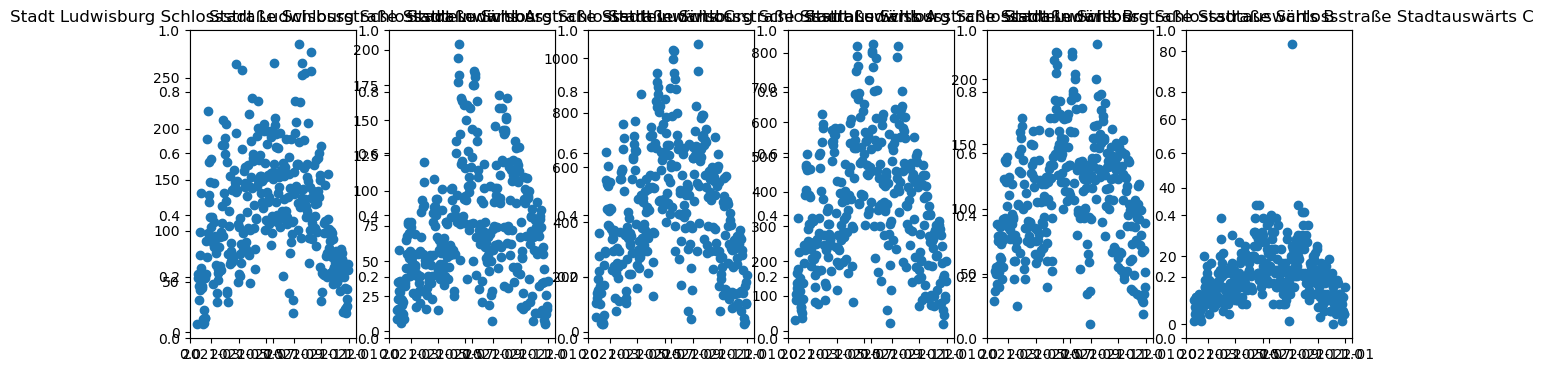

<Figure size 640x480 with 0 Axes>

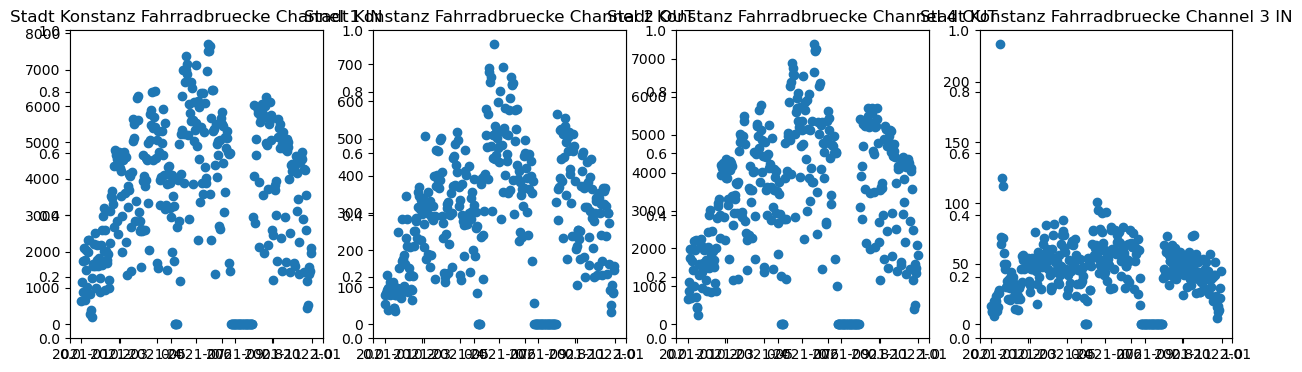

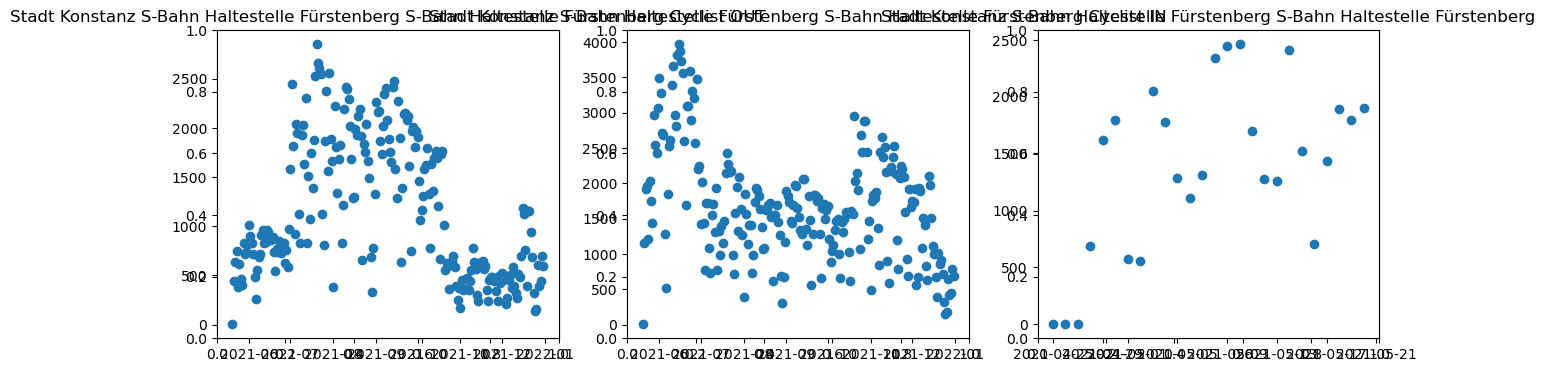

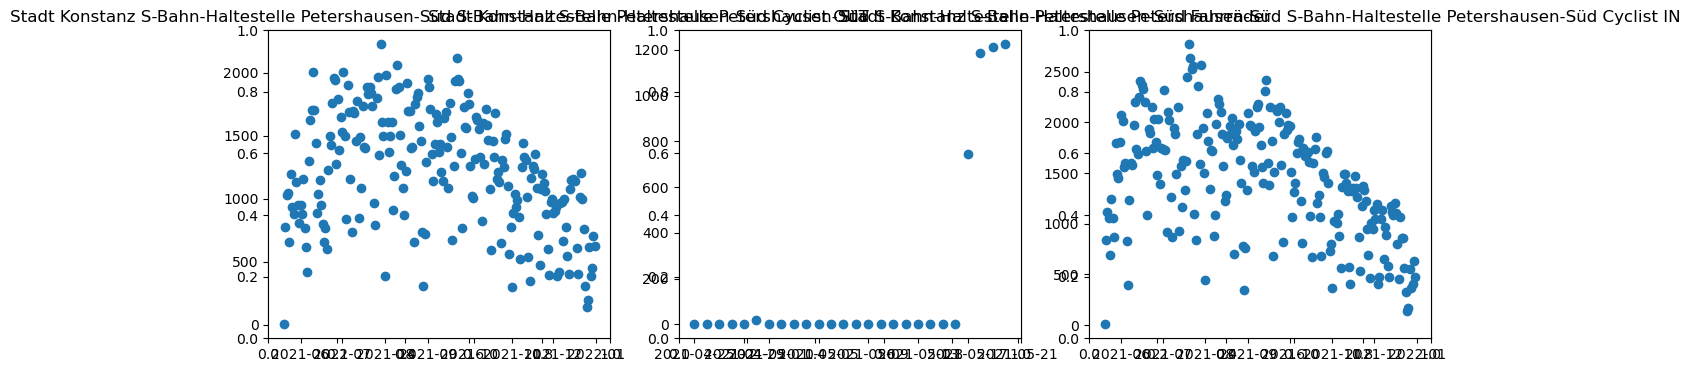

<Figure size 640x480 with 0 Axes>

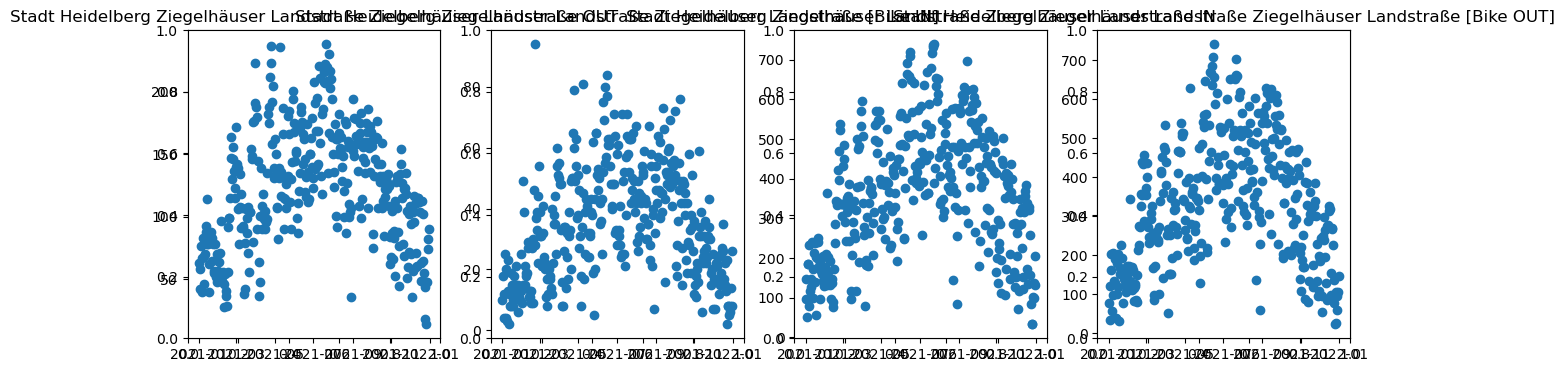

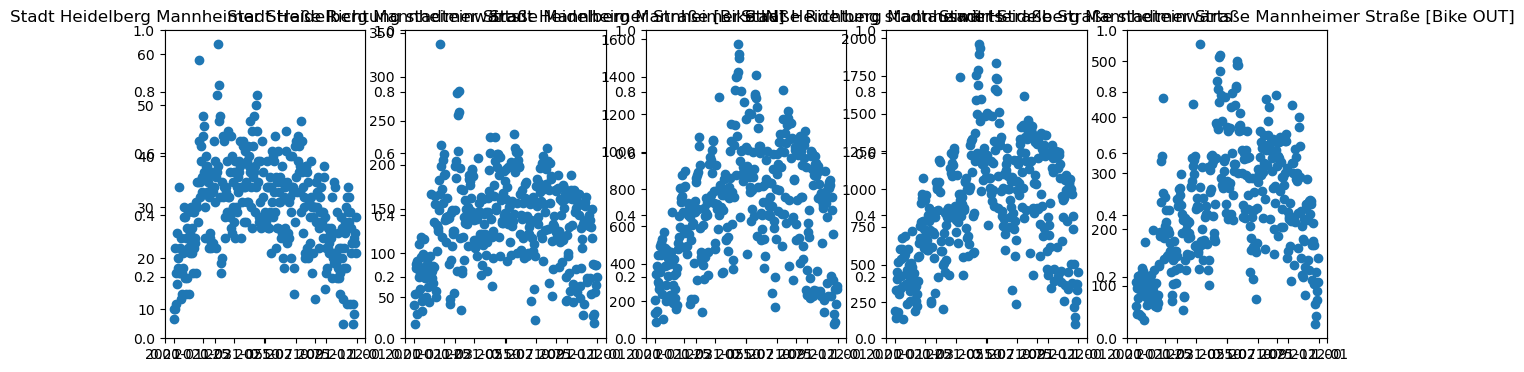

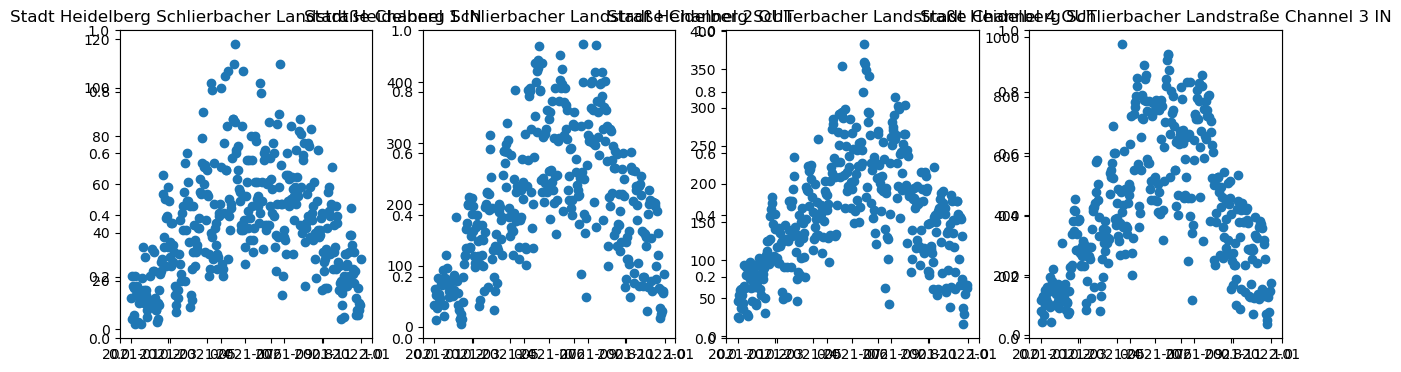

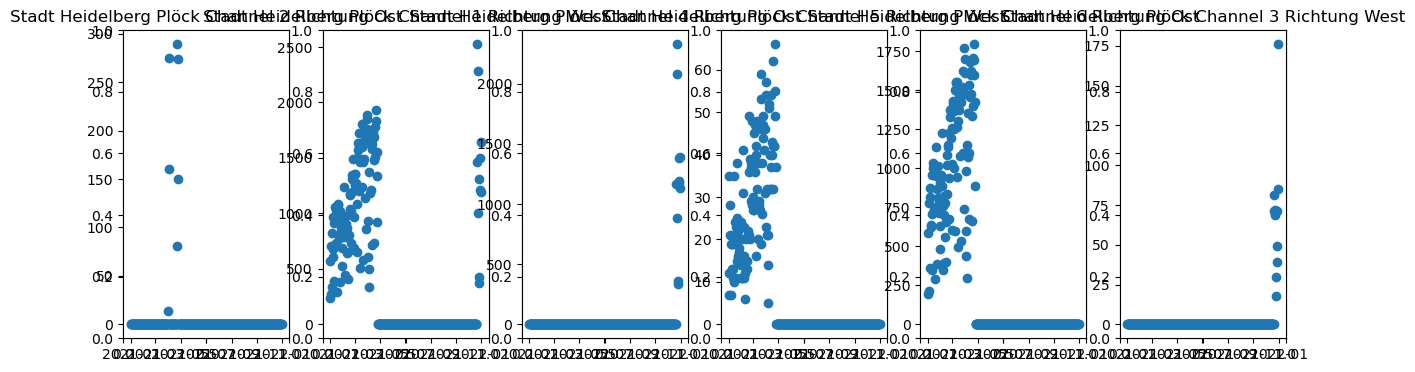

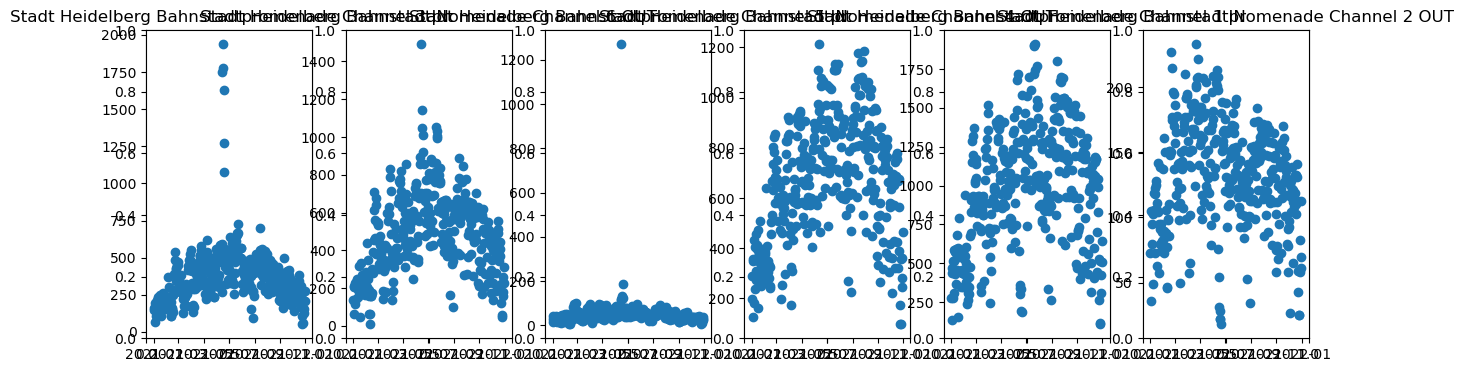

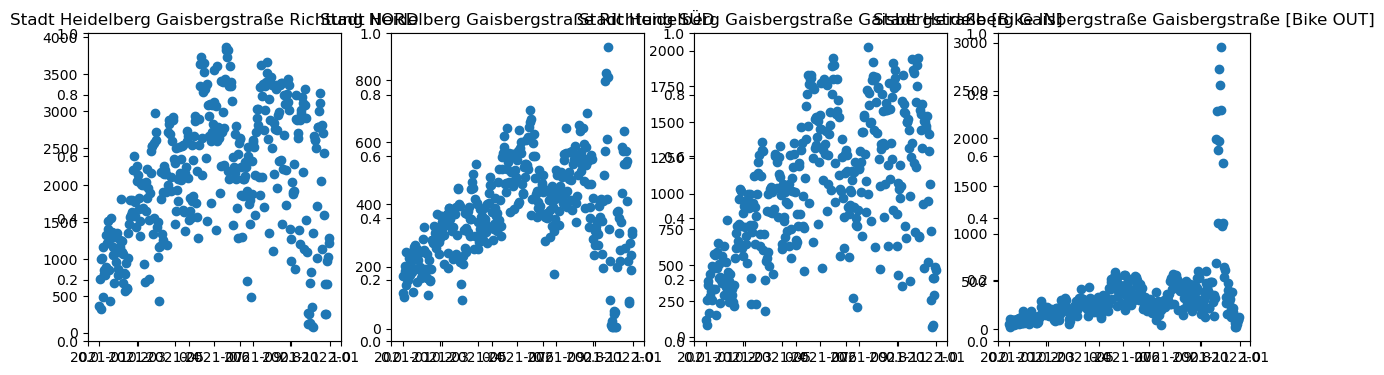

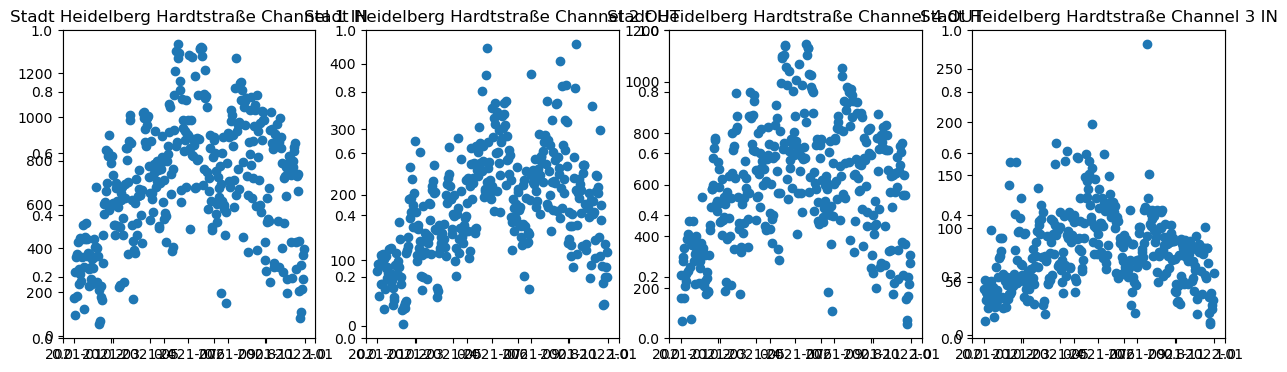

<Figure size 640x480 with 0 Axes>

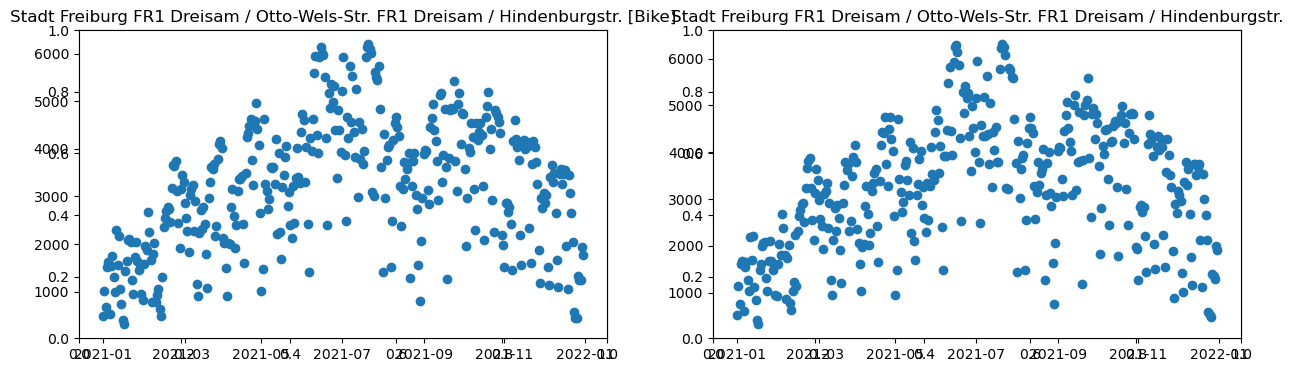

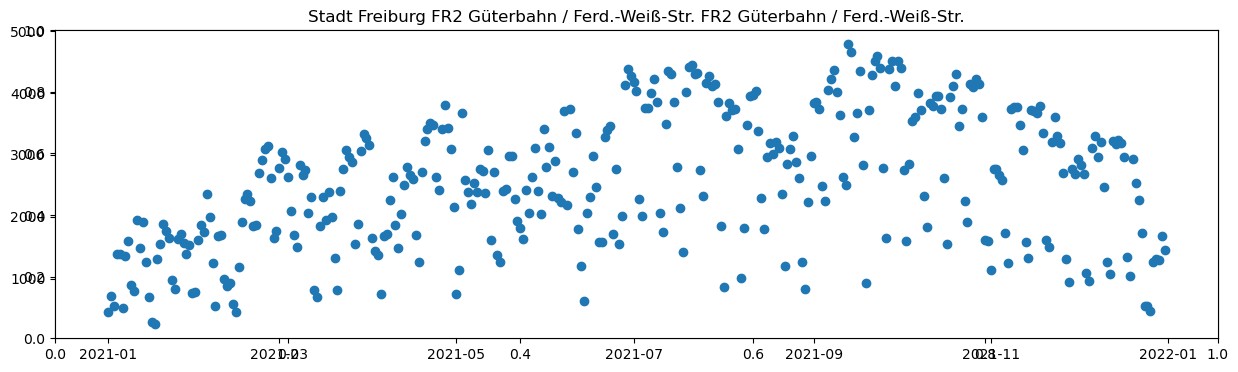

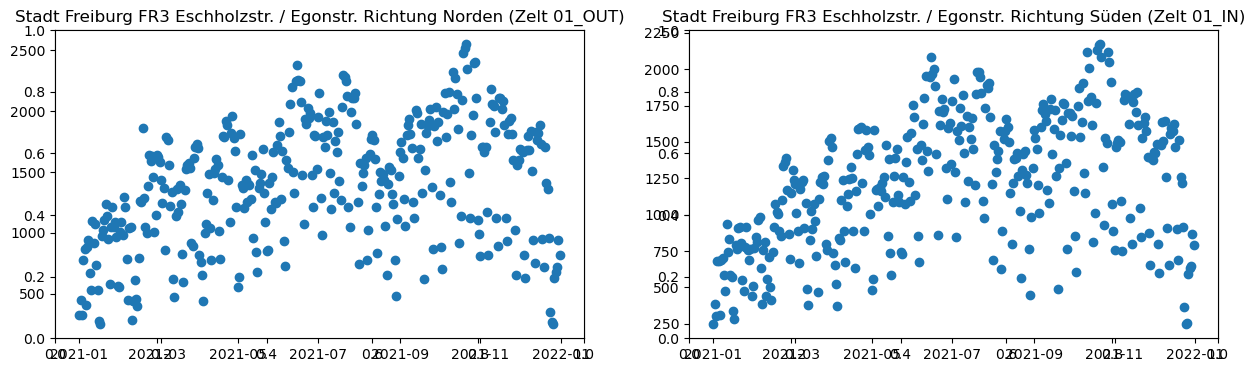

<Figure size 640x480 with 0 Axes>

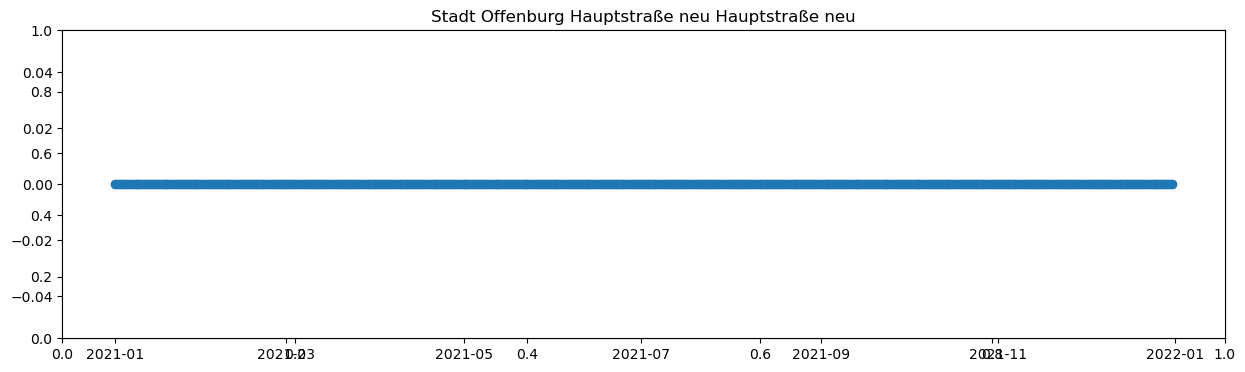

<Figure size 640x480 with 0 Axes>

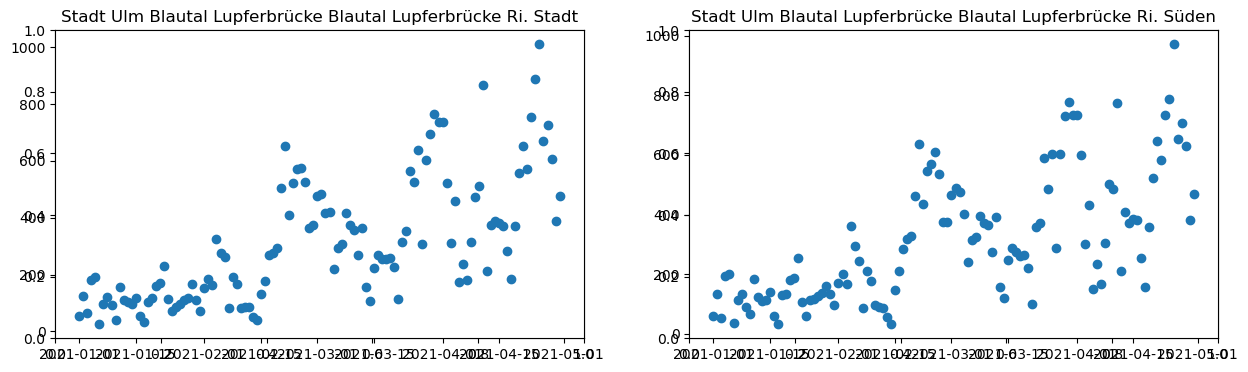

In [8]:
# TODO inspect whole dataset:
#   - which counter sites with channels exist in the different cities
#   - are there zero counts for some counter sites?
# TODO this cell is only for data inspection, plotting is not pretty...

for cityname in cities:
    plt.figure()
    
    print('\n')
    print('city: ', cityname)
    
    # extract data for city
    citydat = counters_by_daytype_daily.loc[counters_by_daytype_daily['standort']==cityname]
    
    print('citydat.shape: ', citydat.shape)
    
    # get counter sites in city
    counter_sites = list(set(citydat['counter_site'])) # TODO check whether counter_site - counter_side_id is a 1:1 mapping
    
    # for each counter site
    for counter_site in counter_sites:
        
        print('\t countersite: ', counter_site)
        
        # extract data for counter site
        countersitedat = citydat.loc[citydat['counter_site']==counter_site]
        print('\t countersitedat.shape: ', countersitedat.shape)
        
        # get channels at counter site
        channels = list(set(countersitedat['channel_name'])) # TODO check whether channel_name - channel_id is a 1:1 mapping
        
        
        # initialize figure
        #plt.figure()
        fig, ax = plt.subplots(nrows=1, ncols=len(channels), figsize=(15,4))
        
        for i, channel in enumerate(channels):
            
            print('\t \t channel name: ', channel)
            
            # extract channel dat
            channeldat = countersitedat.loc[countersitedat['channel_name']==channel]
            print('\t \t channeldat.shape: ', channeldat.shape)
            
            # plot
            ax = fig.add_subplot(1, len(channels), 1 + i)
            plt.scatter(channeldat['date'], channeldat['zählstand'])
            plt.title(cityname + ' ' + counter_site + ' ' + channel)


### Extract daily counts of a single channel in Freiburg

For the analysis, consider the daily bike rider counts from a single counting channel in Freiburg.

shape:  (365, 6)


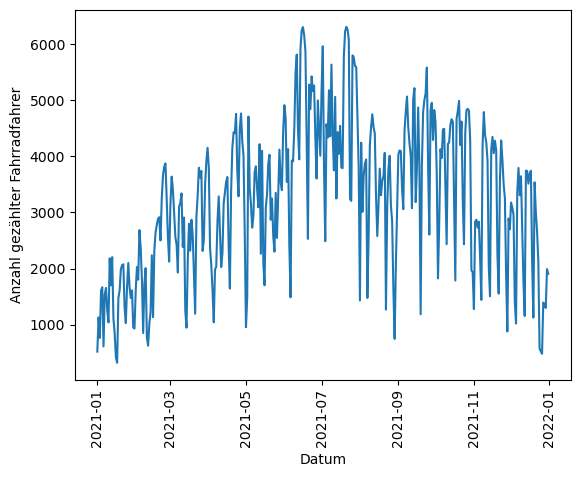

In [9]:
# plot daily counts of Freiburg at one counter site and for one channel for one year
# (TODO rausfinden, was die verschiedenen Channels sind)

# counting station
city_name = 'Stadt Freiburg'
counter_site = 'FR1 Dreisam / Otto-Wels-Str.'
channel_name = 'FR1 Dreisam / Hindenburgstr.'

# extract data
fr1_dat = counters_by_daytype_daily[(counters_by_daytype_daily.standort == city_name) & (counters_by_daytype_daily.counter_site == counter_site) & (counters_by_daytype_daily.channel_name == channel_name)]

# print shape
print('shape: ', fr1_dat.shape) # daily summed measurements for each of the 365 days in 2021

# plot daily counts for this channel
plt.plot(fr1_dat['date'], fr1_dat['zählstand'])
plt.xticks(rotation=90)
plt.xlabel('Datum')
plt.ylabel('Anzahl gezählter Fahrradfahrer');

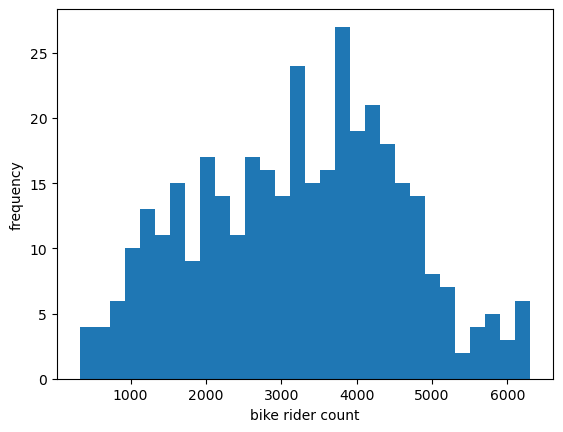

In [10]:
# plot histogram of bike rider counts
plt.hist(fr1_dat['zählstand'], bins=30) # TODO Verteilung?
plt.xlabel('bike rider count')
plt.ylabel('frequency');

In [11]:
fr1_dat

,standort,counter_site,channel_name,date,is_busday,zählstand
0,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-01,True,521
1,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-02,False,1131
2,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-03,False,764
3,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-04,True,1607
4,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-05,True,1668
...,...,...,...,...,...,...
360,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-12-27,True,1395
361,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-12-28,True,1357
362,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-12-29,True,1299
363,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-12-30,True,1991


## Find and import temperature data

In [12]:
# find coordinates of channel location
print('latitude:', set(dat[(dat.standort == city_name) & (dat.counter_site == counter_site) & (dat.channel_name == channel_name)]['latitude']))
print('longitude:', set(dat[(dat.standort == city_name) & (dat.counter_site == counter_site) & (dat.channel_name == channel_name)]['longitude']))

# Given the location, one can download the temperature data from https://open-meteo.com/en/docs/historical-weather-api.
# TODO Temperature data is inaccurate. See comment in ./../data/raw/temperature/README.md

latitude: {47.99054}
longitude: {7.8623013}


In [13]:
# import temperature data for the given location of the counting station
weather_dat = pd.read_csv('./../data/raw/temperature/temperature_FR1-Dreisam-Hindenburgerstr_lat-48-25_long-7-5.csv', header=2)
weather_dat

,time,temperature_2m (°C),relativehumidity_2m (%),apparent_temperature (°C),precipitation (mm),cloudcover (%)
0,2021-01-01T00:00,3.3,91,0.8,0.0,100
1,2021-01-01T01:00,2.8,93,0.2,0.0,100
2,2021-01-01T02:00,2.6,93,-0.1,0.0,100
3,2021-01-01T03:00,2.3,95,-0.3,0.1,100
4,2021-01-01T04:00,2.0,96,-0.4,0.0,100
...,...,...,...,...,...,...
8755,2021-12-31T19:00,8.6,91,6.4,0.0,21
8756,2021-12-31T20:00,7.8,94,5.6,0.0,21
8757,2021-12-31T21:00,7.3,95,5.2,0.0,16
8758,2021-12-31T22:00,6.3,97,4.0,0.0,17


In [14]:
# convert to date
weather_dat['time'] = pd.to_datetime(weather_dat['time'])

# add simpler date format to each measurement to make grouping by day easier
weather_dat['date'] = weather_dat['time'].dt.date

Compute daily average temperature:

In [15]:
# get daily mean temperature
daily_mean_temp = weather_dat.groupby(by=['date'], as_index=False)['temperature_2m (°C)'].mean()
daily_mean_temp

,date,temperature_2m (°C)
0,2021-01-01,1.845833
1,2021-01-02,0.845833
2,2021-01-03,0.495833
3,2021-01-04,0.733333
4,2021-01-05,0.616667
...,...,...
360,2021-12-27,7.466667
361,2021-12-28,9.925000
362,2021-12-29,9.554167
363,2021-12-30,13.116667


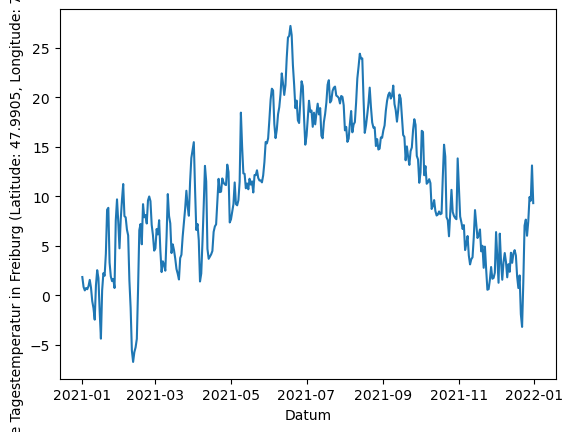

In [16]:
# plot daily mean temperature
plt.plot(daily_mean_temp['date'], daily_mean_temp['temperature_2m (°C)'])
plt.xlabel('Datum')
plt.ylabel('Mittlere Tagestemperatur in Freiburg (Latitude: 47.9905, Longitude: 7.8619) in °C');

## Merge bike rider counts and temperature information

In [17]:
# combine the daily bikerider counts and temperature information
combined_daily_dat = pd.merge(fr1_dat, daily_mean_temp, on='date')
combined_daily_dat

,standort,counter_site,channel_name,date,is_busday,zählstand,temperature_2m (°C)
0,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-01,True,521,1.845833
1,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-02,False,1131,0.845833
2,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-03,False,764,0.495833
3,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-04,True,1607,0.733333
4,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-05,True,1668,0.616667
...,...,...,...,...,...,...,...
360,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-12-27,True,1395,7.466667
361,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-12-28,True,1357,9.925000
362,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-12-29,True,1299,9.554167
363,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-12-30,True,1991,13.116667


In [18]:
# adjust column names
combined_daily_dat.rename(columns = {'temperature_2m (°C)':'temperature', 'zählstand':'rider_count'}, inplace = True)
combined_daily_dat

,standort,counter_site,channel_name,date,is_busday,rider_count,temperature
0,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-01,True,521,1.845833
1,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-02,False,1131,0.845833
2,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-03,False,764,0.495833
3,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-04,True,1607,0.733333
4,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-05,True,1668,0.616667
...,...,...,...,...,...,...,...
360,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-12-27,True,1395,7.466667
361,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-12-28,True,1357,9.925000
362,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-12-29,True,1299,9.554167
363,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-12-30,True,1991,13.116667


In [19]:
# reorder columns to have the dependent variable in the last column
combined_daily_dat = combined_daily_dat[['standort', 'counter_site', 'channel_name', 'date', 'temperature', 'is_busday', 'rider_count']]
combined_daily_dat

,standort,counter_site,channel_name,date,temperature,is_busday,rider_count
0,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-01,1.845833,True,521
1,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-02,0.845833,False,1131
2,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-03,0.495833,False,764
3,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-04,0.733333,True,1607
4,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-05,0.616667,True,1668
...,...,...,...,...,...,...,...
360,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-12-27,7.466667,True,1395
361,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-12-28,9.925000,True,1357
362,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-12-29,9.554167,True,1299
363,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-12-30,13.116667,True,1991


In [20]:
# TODO maybe restrict the exportet dataset to the columns 'is_busday', 'rider_count', 'temperature'
# (so far, I didn't do it to keep in mind that we only consider data of one channel)

In [21]:
# export dataframe
combined_daily_dat.to_pickle('./../data/processed/combined_daily_dat_FR1.pkl')